In [ ]:
# create 5-fold cross validation files for CycPeptMPDB regression data
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# load cycpeptmpdb_regression.csv
cycpeptmpdb_regression_df = pd.read_csv("training_data/regression_data/cycpeptmpdb_regression.csv")
print(len(cycpeptmpdb_regression_df))
cycpeptmpdb_regression_df = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['PAMPA'] != -10].reset_index(drop=True)
print(len(cycpeptmpdb_regression_df))

In [ ]:
# Import libraries
from collections import OrderedDict
import pandas as pd
import torch
from roformer import RoFormerForMaskedLM, RoFormerConfig #, RoFormerForMaskedLM,
from tokenizer.my_tokenizers import SMILES_SPE_Tokenizer


In [ ]:
# Load tokenizer #################################################################
vocab_file = 'tokenizer/new_vocab.txt'
splits_file = 'tokenizer/new_splits.txt'

tokenizer = SMILES_SPE_Tokenizer(vocab_file, splits_file)

# set model configuration ###############################################################
config = RoFormerConfig(
    vocab_size=tokenizer.vocab_size,
    embedding_size=768,
    max_position_embeddings=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    hidden_size=768,
    intermediate_size=3072,
    type_vocab_size=2,
    pad_token_id=tokenizer.pad_token_id,
    is_decoder=False,
    num_labels=1,
    hidden_dropout_prob=0,
    attention_probs_dropout_prob=0,
    problem_type='regression'
)

model = RoFormerForMaskedLM(config=config)
# model = reset_parameters(model)

# Define checkpoints ###############################################################
pretraining_checkpoint = 'checkpoints/2024-05-28_FirstPepLM_onRandom_peps/pepLM-epoch=09-step=412739-val_loss=0.292.ckpt'
# checkpoint_1 = 'checkpoints/2024-06-05_cycpept_penetrance_5fold_0/PepLM_AUROC-epoch=999-step=39000-val_auroc=0.869.ckpt'
# checkpoint_2 = 'checkpoints/2024-06-05_cycpept_penetrance_5fold_1/PepLM_AUROC-epoch=999-step=39000-val_auroc=0.881.ckpt'
# checkpoint_3 = 'checkpoints/2024-06-05_cycpept_penetrance_5fold_2/PepLM_AUROC-epoch=999-step=39000-val_auroc=0.872.ckpt'
# checkpoint_4 = 'checkpoints/2024-06-05_cycpept_penetrance_5fold_3/PepLM_AUROC-epoch=918-step=35841-val_auroc=0.873.ckpt'
# checkpoint_5 = 'checkpoints/2024-06-05_cycpept_penetrance_5fold_4/PepLM_AUROC-epoch=936-step=36543-val_auroc=0.875.ckpt'
# checkpoint_full_training = 'checkpoints/2024-06-04_CLS_Full_finetune/PepLM_AUROC-epoch=701-step=34398-val_auroc=0.876.ckpt'

checkpoint = pretraining_checkpoint

checkpoint_data = torch.load(checkpoint, map_location='cpu')

new_state_dict = OrderedDict()
for k, v in checkpoint_data['state_dict'].items():
    name = k[6:]
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

In [ ]:
# Encode data ####################################################################
# model and data to cuda
model.to('cuda')
model.eval()


def encode_data(data, tokenizer):
    encoded_data = []
    for i, row in data.iterrows():
        smiles = row['SMILES']
        encoded = tokenizer.encode_plus(smiles, return_tensors='pt')
        encoded_data.append(encoded)
    return encoded_data

encoded_data = encode_data(cycpeptmpdb_regression_df, tokenizer)
encoded_data

In [14]:
from tqdm import tqdm

# encoded_data to cuda
for encoded in encoded_data:
    for k, v in encoded.items():
        encoded[k] = v.to('cuda')

# only use GPU 1-6
# torch.cuda.set_device(0)

cls_embeddings = []

for encoded in tqdm(encoded_data[:]):
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, return_dict=True, output_hidden_states=True)
    cls_embeddings.append(outputs.hidden_states[-1][0][0])


100%|██████████| 6701/6701 [00:39<00:00, 169.24it/s]


In [ ]:
# cls_embeddings

# make embeddings a list
embeddings = [cls_embedding.cpu().numpy() for cls_embedding in cls_embeddings]


In [19]:
# add embeddings to dataframe
# cycpeptmpdb_regression_df['embeddings'] = embeddings

# save to csv
cycpeptmpdb_regression_df.to_csv('training_data/regression_data/cycpeptmpdb_embeddings.csv', index=False)

# cycpeptmpdb_regression_df.head()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


In [ ]:
# conduct PCA on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

embeddings_pca = pca.fit_transform(embeddings)


In [ ]:
# conduct UMAP on embeddings
import umap

umap_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine').fit_transform(embeddings)


6701


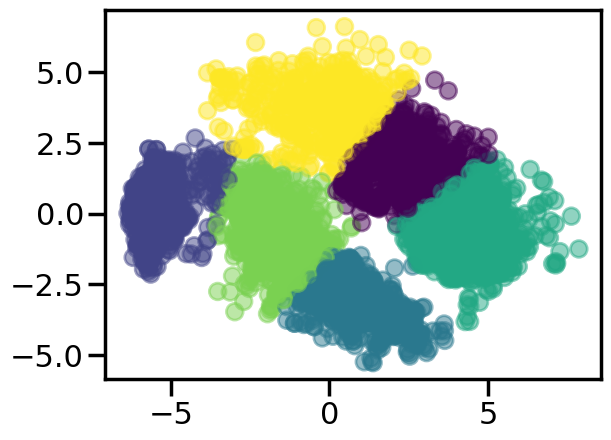

In [100]:
print(len(cycpeptmpdb_regression_df))

# split pca_columns into two separate columns
list_pcas = [list(x) for x in embeddings_pca]
x = [i[0] for i in list_pcas]
y = [i[1] for i in list_pcas]
plt.scatter(x, y, alpha=0.5, c=cycpeptmpdb_regression_df['pca_cluster'])



In [101]:
cycpeptmpdb_regression_df['pca_cluster'].value_counts()


pca_cluster
1    1506
3    1486
0    1093
4    1079
2     949
5     588
Name: count, dtype: int64

In [25]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
data = embeddings_pca


/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 0, 1, ..., 1, 5, 0], dtype=int32)

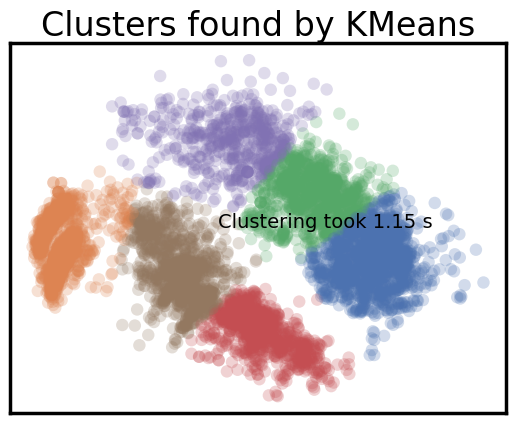

In [43]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})
# count number of samples in each cluster
cluster_labels = cluster.KMeans(n_clusters=6).fit_predict(data)
cluster_labels

In [ ]:
embeddings_pca_list = embeddings_pca.tolist()

cycpeptmpdb_regression_df['pca_columns'] = embeddings_pca_list
cycpeptmpdb_regression_df['cluster'] = cluster_labels


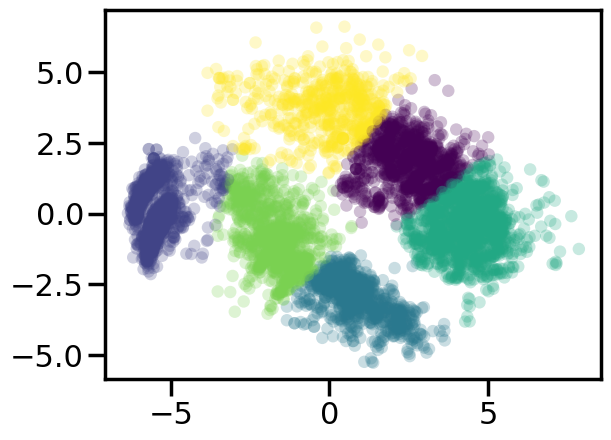

In [55]:
# scatterplot of clusters
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, **plot_kwds)

In [112]:
# split pca_cluster 5 into train, test, and validation sets
kmeans_regression_validation = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['pca_cluster']==5].reset_index(drop=True)

# save to csv
kmeans_regression_validation[['SMILES', 'PAMPA']].to_csv('training_data/kmeans_regression/kmeans_regression_validation.csv', index=False)


In [110]:
kmeans_train_test = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['pca_cluster']!=5].reset_index(drop=True)
kmeans_train_test

kmeans_0 = kmeans_train_test[kmeans_train_test['pca_cluster']==0].reset_index(drop=True)
kmeans_1 = kmeans_train_test[kmeans_train_test['pca_cluster']==1].reset_index(drop=True)
kmeans_2 = kmeans_train_test[kmeans_train_test['pca_cluster']==2].reset_index(drop=True)
kmeans_3 = kmeans_train_test[kmeans_train_test['pca_cluster']==3].reset_index(drop=True)
kmeans_4 = kmeans_train_test[kmeans_train_test['pca_cluster']==4].reset_index(drop=True)

# print length of all dataframes
print(len(kmeans_0), len(kmeans_1), len(kmeans_2), len(kmeans_3), len(kmeans_4), len(kmeans_regression_validation))


1093 1506 949 1486 1079 588


In [111]:
# randomly select 949 samples from each cluster
subset_kmeans_0 = kmeans_0.sample(n=949, random_state=42).reset_index(drop=True)
subset_kmeans_1 = kmeans_1.sample(n=949, random_state=42).reset_index(drop=True)
subset_kmeans_2 = kmeans_2.sample(n=949, random_state=42).reset_index(drop=True)
subset_kmeans_3 = kmeans_3.sample(n=949, random_state=42).reset_index(drop=True)
subset_kmeans_4 = kmeans_4.sample(n=949, random_state=42).reset_index(drop=True)

print(len(subset_kmeans_0), len(subset_kmeans_1), len(subset_kmeans_2), len(subset_kmeans_3), len(subset_kmeans_4), len(kmeans_regression_validation))

949 949 949 949 949 588


In [114]:
# train 1
train_1 = pd.concat([subset_kmeans_0, subset_kmeans_1, subset_kmeans_2, subset_kmeans_3]).reset_index(drop=True)
train_2 = pd.concat([subset_kmeans_0, subset_kmeans_1, subset_kmeans_2, subset_kmeans_4]).reset_index(drop=True)
train_3 = pd.concat([subset_kmeans_0, subset_kmeans_1, subset_kmeans_3, subset_kmeans_4]).reset_index(drop=True)
train_4 = pd.concat([subset_kmeans_0, subset_kmeans_2, subset_kmeans_3, subset_kmeans_4]).reset_index(drop=True)
train_5 = pd.concat([subset_kmeans_1, subset_kmeans_2, subset_kmeans_3, subset_kmeans_4]).reset_index(drop=True)

test_1 = subset_kmeans_4
test_2 = subset_kmeans_3
test_3 = subset_kmeans_2
test_4 = subset_kmeans_1
test_5 = subset_kmeans_0

# save all
train_1[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/train_1.csv', index=False)
train_2[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/train_2.csv', index=False)
train_3[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/train_3.csv', index=False)
train_4[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/train_4.csv', index=False)
train_5[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/train_5.csv', index=False)

test_1[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/test_1.csv', index=False)
test_2[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/test_2.csv', index=False)
test_3[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/test_3.csv', index=False)
test_4[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/test_4.csv', index=False)
test_5[['SMILES','PAMPA']].to_csv('training_data/kmeans_regression/test_5.csv', index=False)


In [ ]:
import pandas as pd
dataset_df = pd.read_csv('training_data/regression_data/cycpeptmpdb_embeddings_umap_pca.csv')


In [ ]:
import ast

def split_pca_columns(row):
    pca1, pca2 = ast.literal_eval(row['pca_columns'])
    return pd.Series([pca1, pca2])

dataset_df[['pca1', 'pca2']] = dataset_df.apply(split_pca_columns, axis=1)


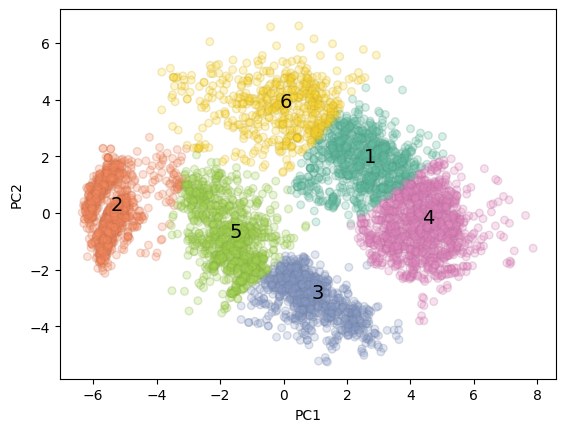

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from matplotlib.colors import ListedColormap

# Function to split PCA columns
def split_pca_columns(row):
    pca1, pca2 = ast.literal_eval(row['pca_columns'])
    return pd.Series([pca1, pca2])

# Read the dataset
dataset_df = pd.read_csv('training_data/regression_data/cycpeptmpdb_embeddings_umap_pca.csv')
dataset_df[['pca1', 'pca2']] = dataset_df.apply(split_pca_columns, axis=1)

# Create a custom colormap
oldcmp = plt.get_cmap('Set2')
newcmp = ListedColormap(oldcmp.colors[:6])

# Function to darken colors
def darken_color(color, amount=0.8):
    c = np.array(color)
    return np.clip(c * amount, 0, 1)

# Extract the colors from the colormap and darken them
cluster_indices = dataset_df['pca_cluster'] / dataset_df['pca_cluster'].max()
colors = newcmp(cluster_indices)
dark_colors = [darken_color(color) for color in colors]

# Plot the scatter plot with darkened edgecolors
plt.scatter(dataset_df['pca1'], dataset_df['pca2'], alpha=0.25, c=dataset_df['pca_cluster'], cmap=newcmp, s=30, edgecolors=dark_colors)

# Find cluster centers for PCA
cluster_centers = []
for i in range(6):
    cluster_center = dataset_df[dataset_df['pca_cluster'] == i][['pca1', 'pca2']].mean()
    cluster_centers.append(cluster_center)

# Add cluster centers with numbers
for i, txt in enumerate(cluster_centers):
    plt.annotate(i + 1, (txt[0], txt[1]), fontsize=14)

# Add labels PCA 1 and PCA 2
plt.xlabel('PC1')  # Label for the x-axis
plt.ylabel('PC2')  # Label for the y-axis

# Save the plot
plt.savefig('figures/kmeans_forPub.png', dpi=300)
plt.savefig('figures/kmeans_forPub.svg')
